### Study of the bursting dynamcis of the nodes

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')
#sys.path.insert(1, '/home/vinicius/GrayData-Analysis/GDa/it/src')
from   GDa.session           import session_info, session
from   GDa.spectral_analysis import filtering, time_frequency
from   GDa.misc.create_grids import create_stages_time_grid
from   GDa.graphics.plot_brain_sketch import plot_node_brain_sketch, plot_edge_brain_sketch
from   GDa.it.discrete       import *
import multiprocessing
from   joblib                import Parallel, delayed
import numpy             as np
import matplotlib.pyplot as plt
import scipy
import time
from   tqdm              import tqdm

#### Define stage and band names

In [2]:
stages      = ['baseline', 'cue', 'delay', 'match']
band_names  = [r'$\theta$', r'$\alpha$', r'$\beta$', r'low-$\gamma$ ', r'high-$\gamma$' ]

In [3]:
# Auxiliary function to smooth
def smooth(x, w=5):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')

# Compute z-score of time series
def z_score(x):
    return (x-x.mean())/x.std()

### Instantiating session object

In [4]:
# Instantiate class|
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
              slvr_msmod = False, align_to = 'cue', trial_type = 1, \
              behavioral_response = 1, evt_dt = [-0.65, 3.0])
# Read data from .mat files
ses.read_from_mat()

In [5]:
# Defining frequencies
delta      = [4,8]
alpha      = [8,16]
beta       = [16,40] 
low_gamma  = [40, 70]  
high_gamma = [70, 150]
bands      = [delta, alpha, beta, low_gamma, high_gamma]
freqs = np.arange(4,150,1)

# Morlet
W = time_frequency.wavelet_transform(data = ses.data, baseline_correction = False, 
                                     fs = ses.readinfo['fsample'], freqs = freqs, n_cycles = freqs/2,
                                     time_bandwidth = None, delta = 15, method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:  1.1min remaining:  1.5min
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:  1.2min remaining:   44.6s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:  1.3min remaining:   17.2s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:  1.4min finished


In [6]:
tarray = ses.readinfo['tarray'][::15][20:-20]
print(tarray.shape)

(204,)


In [7]:
W.shape

(540, 49, 146, 244)

In [8]:
### Power spectra
S = ( W[:,:,:,20:-20] * np.conj(W[:,:,:,20:-20]) ).real

In [9]:
S.shape

(540, 49, 146, 204)

In [10]:
S_avg = np.zeros([S.shape[0], S.shape[1], len(bands), S.shape[3]])
# Averaging over bands
for i in tqdm( range(len(bands)) ):
    band = bands[i]
    fidx = (freqs>=band[0])*(freqs<band[1])
    S_avg[:,:,i,:] = S[:,:,fidx,:].mean(axis=2)

100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


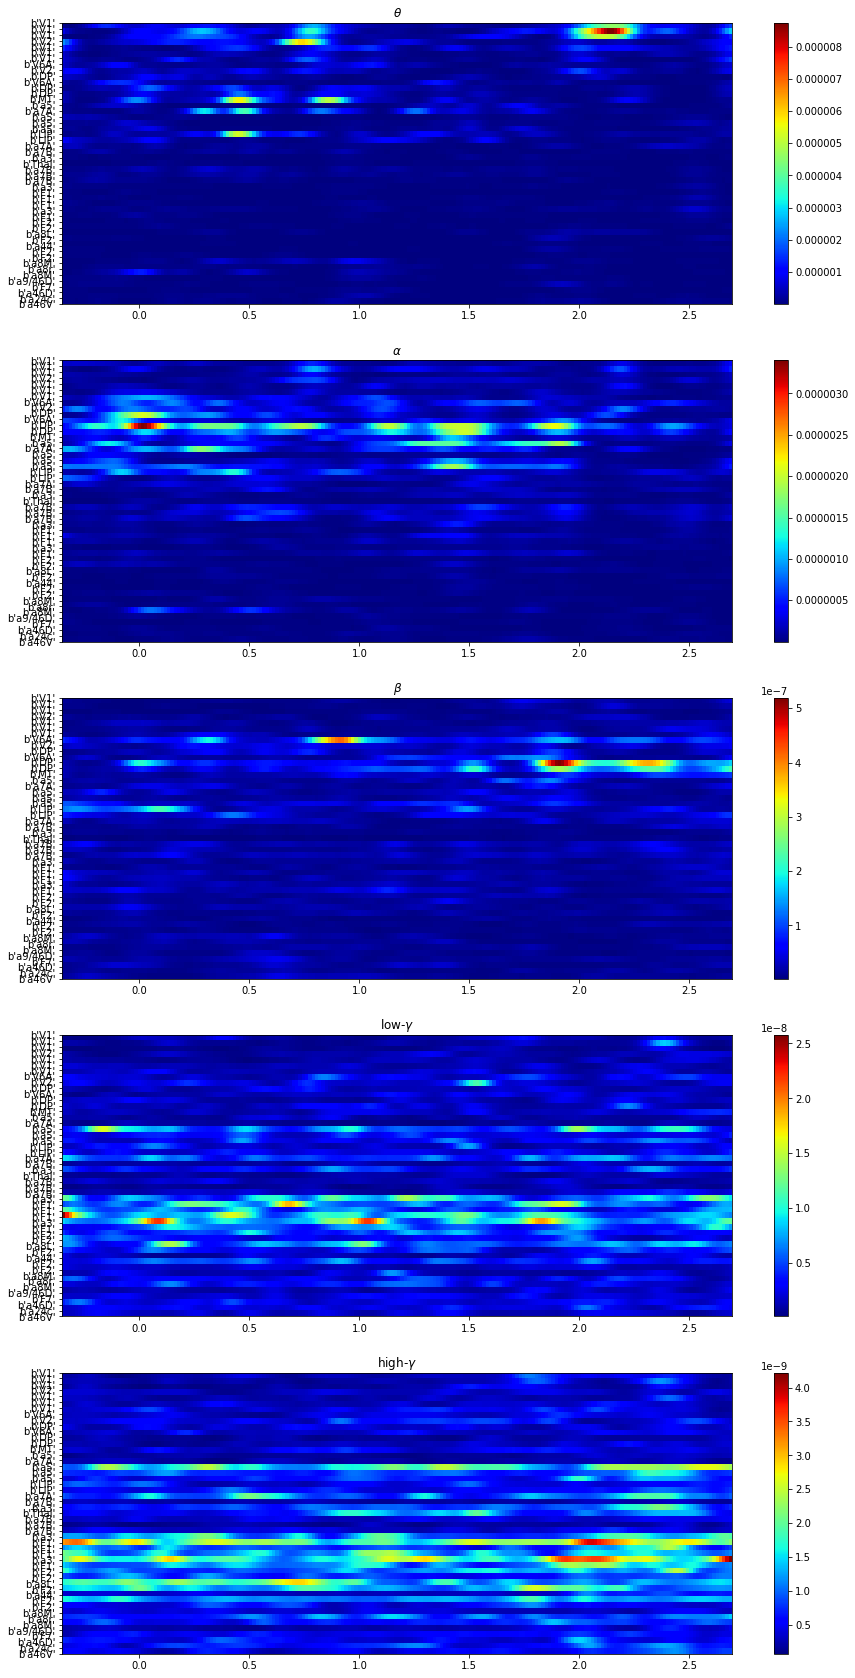

In [11]:
plt.figure(figsize=(15,30))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(S_avg[40,:,i,:],aspect='auto',cmap='jet',origin='lower', 
               extent=[tarray[0],tarray[-1],0,48])
    plt.title(band_names[i])
    plt.yticks(range(49), ses.readinfo['areas'])
    plt.colorbar()

#### Mask to track stages

In [12]:
t_mask = create_stages_time_grid(ses.readinfo['t_cue_on'], ses.readinfo['t_cue_off'], ses.readinfo['t_match_on'], 
                                 ses.readinfo['fsample'], tarray, ses.readinfo['nT'])

In [13]:
raster = np.zeros_like(S_avg)
for i in tqdm( range(len(bands)) ):
    for T in range(ses.readinfo['nT']):
        thr = scipy.stats.mstats.mquantiles(S_avg[T,:,i,:], prob=.80, axis=-1)
        raster[T,:,i,:]= (S_avg[T,:,i,:]>thr).astype(int)

100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


#### Reshape raster to concatenate trials

In [14]:
print(raster.shape)

(540, 49, 5, 204)


In [15]:
r = raster.swapaxes(0,2).reshape(5,49,204*540)

In [16]:
print(r.shape)

(5, 49, 110160)


In [17]:
#### Comparing MI and CC

In [18]:
x = r[-1,np.random.randint(49),:].astype(int)
y = r[-1,np.random.randint(49),:].astype(int)

In [19]:
lags = np.arange(-100,101,1)

In [20]:
MI = np.array([BinLaggedMutualInformation(x,y,lag=l,use='MI') for l in lags])
CC = np.array([BinLaggedMutualInformation(x,y,lag=l,use='CC') for l in lags])

Text(0.5, 0, 'Lag')

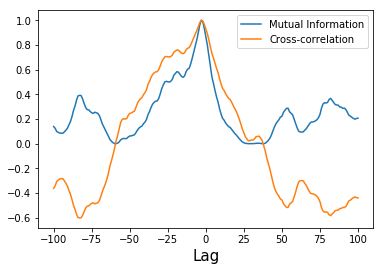

In [21]:
plt.plot(lags, MI/MI.max(), label='Mutual Information')
plt.plot(lags, CC/CC.max(), label='Cross-correlation')
plt.legend()
plt.xlabel('Lag',fontsize=15)

### Lagged mutual information

#### Testing the method for gamma band

In [22]:
MI, tau = pairwiseMI(r[-1,:,t_mask[2]].T, ses.readinfo['pairs'], -100, 100, 'CC', 40)

In [23]:
I = np.zeros([ses.readinfo['nC'],ses.readinfo['nC']])
T = np.zeros([ses.readinfo['nC'],ses.readinfo['nC']])
for i in tqdm( range(ses.readinfo['nP']) ):
    ch1, ch2   = ses.readinfo['pairs'][i,0], ses.readinfo['pairs'][i,1]
    I[ch1,ch2] = I[ch2,ch1] = MI[i]
    T[ch1,ch2] = T[ch2,ch1] = tau[i]

100%|██████████| 1176/1176 [00:00<00:00, 198594.90it/s]


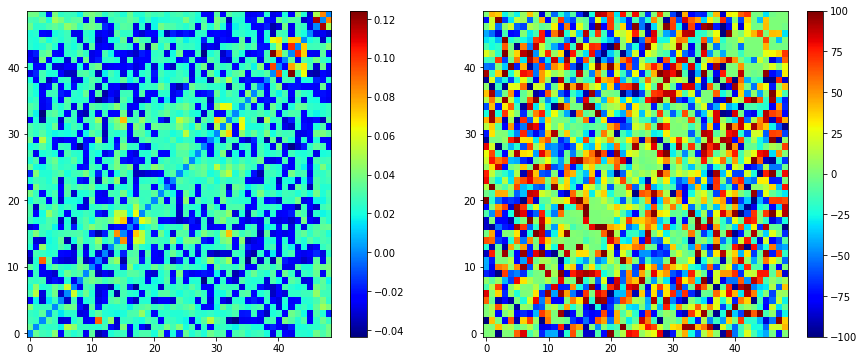

In [24]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow(I, aspect='auto',cmap='jet',origin='lower'); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(T, aspect='auto',cmap='jet',origin='lower'); plt.colorbar()

Text(0.5, 0, '$\\tau$')

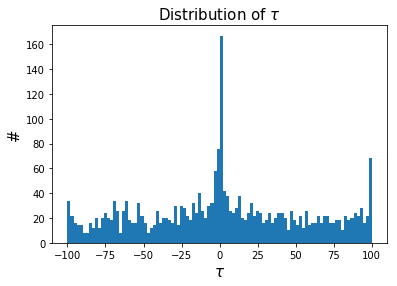

In [25]:
plt.hist(T.flatten(order='C'), 100)
plt.title(r'Distribution of $\tau$', fontsize=15)
plt.ylabel('#', fontsize=15)
plt.xlabel(r'$\tau$', fontsize=15)

In [26]:
#### Computing for each task stage

100%|██████████| 4/4 [00:21<00:00,  5.45s/it]


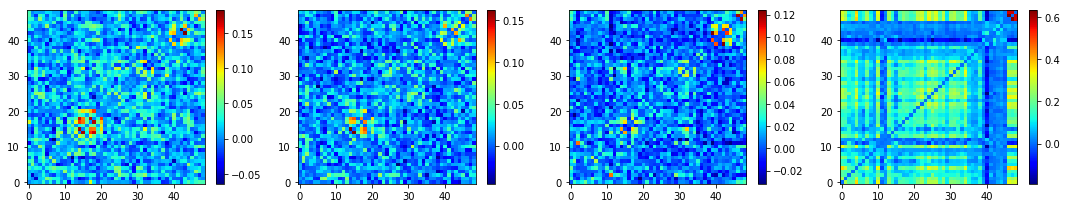

In [27]:
plt.figure(figsize=(15,3))
count = 1
for s in tqdm( range(len(t_mask)) ):
    MI, tau = pairwiseMI(r[-1,:,t_mask[s]].T, ses.readinfo['pairs'], 0, 0, 'CC', 40)
    for i in range(ses.readinfo['nP']):
        ch1, ch2   = ses.readinfo['pairs'][i,0], ses.readinfo['pairs'][i,1]
        I[ch1,ch2] = I[ch2,ch1] = MI[i]
        T[ch1,ch2] = T[ch2,ch1] = tau[i]
    plt.subplot(1,len(t_mask),count)
    plt.imshow(I, aspect='auto',cmap='jet',origin='lower'); plt.colorbar()
    count += 1
plt.tight_layout()

100%|██████████| 4/4 [00:31<00:00,  7.77s/it]


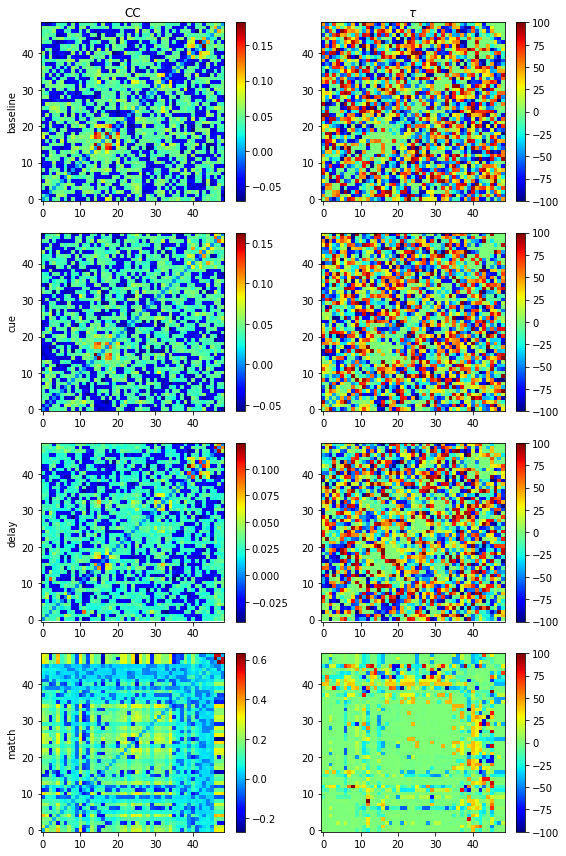

In [28]:
plt.figure(figsize=(8,12))
count = 1
for s in tqdm( range(len(t_mask)) ):
    MI, tau = pairwiseMI(r[-1,:,t_mask[s]].T, ses.readinfo['pairs'], -100, 100, 'CC', 40)
    for i in range(ses.readinfo['nP']):
        ch1, ch2   = ses.readinfo['pairs'][i,0], ses.readinfo['pairs'][i,1]
        I[ch1,ch2] = I[ch2,ch1] = MI[i]
        T[ch1,ch2] = T[ch2,ch1] = tau[i]
    plt.subplot(len(t_mask),2,count)
    plt.imshow(I, aspect='auto',cmap='jet',origin='lower'); plt.colorbar()
    plt.ylabel(stages[s])
    if s == 0: plt.title('CC')
    count += 1
    plt.subplot(len(t_mask),2,count)
    plt.imshow(T, aspect='auto',cmap='jet',origin='lower'); plt.colorbar()
    if s == 0: plt.title(r'$\tau$')
    count += 1
plt.tight_layout()